In [127]:
import pandas as pd
import numpy as np
import gzip
from datetime import date,datetime
pd.options.display.max_columns = 8
pd.options.display.max_rows = 50

from scipy import interp
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline


from sklearn.ensemble import  RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc

from sklearn import cross_validation
import time

import xgboost as xgb

In [3]:
logs_path = 'logs_dates3.csv'
logs = pd.read_csv(logs_path,index_col = 0)

In [4]:
def substring_features(data,substrings):
    substr_features = np.array([int(substr in str(data)) for substr in substrings])
    return substr_features

In [5]:
def add_session(value, curr_session,sessions,curr_date,prev_date,time_delta_min,data):
    if curr_date - prev_date < np.timedelta64(time_delta_min,'m'):
        curr_session.append(value)
    else:
        sessions.append(curr_session)
        curr_session = [value]
    return curr_session,sessions

In [6]:
def session_substrings(session_features,sessions_all,substrings,logs_id,
                       logs_col,curr_date,prev_date,time_delta_min,data,sess_len):
    if curr_date - prev_date < np.timedelta64(time_delta_min,'m'):
        session_features += substring_features(data[logs_col].iloc[logs_id],substrings)
    else:
        sessions_all.append(session_features)
        session_features = substring_features(data[logs_col].iloc[logs_id],substrings)
    return session_features,sessions_all

In [7]:
def start_of_session(begins,curr_date,prev_date,time_delta_min,data):
    if curr_date - prev_date >= np.timedelta64(time_delta_min,'m'):
        begins.append(curr_date)
    return begins

In [8]:
def session_counter(data,time_delta_min = 90):
    data = data.sort('date')
    #id в логах текущей сессии пользователя
    sess_ids = []
    #id в логах всех сессий пользователя
    ids = []
    
    sess_times = []
    times = []
    
    
    sess_http = np.zeros(len(http_req))
    http = [] 
    
    sess_visited = np.zeros(len(query_words))
    visited = []
    
    sess_ref = np.zeros(len(referer_words))
    refs = []
    
    sess_bytes = []
    bytes = []
    
    
    sess_status =  np.zeros(len(http_status))
    status = []
    
    sess_gadgets = np.zeros(len(browses_gadgets_names))
    gadgets = []
    
    
    
    prev_date = np.datetime64(data.date.iloc[0])
    
    begins = [prev_date]
    
    for k,curr_datetime in enumerate(data.date):
        curr_date = np.datetime64(curr_datetime)
        sess_len = float(len(sess_ids))
        
        sess_ids,ids = add_session(k, sess_ids,ids,curr_date,prev_date,time_delta_min,data)
        
        
        sess_times,times = add_session(curr_date, sess_times,times,
                                            curr_date,prev_date,time_delta_min,data)
        
        sess_visited,visited = session_substrings(sess_visited,visited,query_words,k,'site',
                                                  curr_date,prev_date,time_delta_min,data,sess_len)
        
        sess_ref,refs = session_substrings(sess_ref,refs,referer_words, k,'referer',curr_date,
                                           prev_date,time_delta_min,data,sess_len)
        
        sess_http,http = session_substrings(sess_http,http,http_req,k,'http_method',curr_date,
                                            prev_date,time_delta_min,data,sess_len)
        
        sess_status,status = session_substrings(sess_status,status,http_status,k,'status',curr_date,
                                                prev_date,time_delta_min,data,sess_len)
        
        sess_gadgets,gadgets = session_substrings(sess_gadgets,gadgets,browses_gadgets_names,k,'info',
                                                  curr_date,prev_date,time_delta_min,data,sess_len)
        
        sess_bytes,bytes = add_session(data['bytes'].iloc[k], sess_bytes,bytes,curr_date,
                                         prev_date,time_delta_min,data)
        
        begins = start_of_session(begins,curr_date,prev_date,time_delta_min,data)
        
        prev_date = curr_date
        
    ids.append(sess_ids)
    times.append(sess_times)
    http.append(sess_http)
    visited.append(sess_visited)
    refs.append(sess_ref)
    bytes.append(sess_bytes)
    status.append(sess_status)
    gadgets.append(sess_gadgets)
    
    #временные интервалы между сессиями
    deltas_starts = map(lambda x: x.item().total_seconds()/60.0,np.diff(begins))
    
    #продолжительности сессий
    sess_length =  map(lambda x: (x[-1] - x[0]).item().total_seconds()/60.0,times)
    #number_of_sessions, av_requests_in_ses, total num of requ,av_duration_of_session, av_get_sess,av_post_ses
    
    #длительность (в запросах к северу) каждой сессии
    req_quant = map(len,ids)
    
    # самые популярные ip для данного пользователя
    ip1, ip2,ip3 = np.max(np.array(data.ip.apply(lambda x: map(float,x.split('.')[:3]))),0)
    
    #регистрация на сайте инвестмент 101
    inv_date = np.datetime64(data['inv101_date'].iloc[0])
    
    
    if np.any(data.bcs_date.isnull()):#если пользователь не клинет БКС
        # 20 августа - последний день в логах
        inv_bcs_date = (np.datetime64('2015-08-21') - inv_date).item().total_seconds()/60.0
    else:#если пользователь клинет БКС
        # разница между датой становления клиентом БКС и регистрацией на сайте инвестмент 101
        inv_bcs_date = (np.datetime64(data['bcs_date'].iloc[0])- inv_date).item().total_seconds()/60.0
        
    '''len(ids) - общее число сессий данного пользователя
       np.average(req_quant) - среднее число запросов за одну сессию данного пользователя
       sum(req_quant) - общее число запросов данного пользователя в логах 
       np.average(sess_length) - средняя продолжительность сессии пользователя (в минутах)
       np.average(map(sum,bytes)) - средний объем запрашиваемой информации  
    '''
    ans = [inv_bcs_date, ip1,ip2,ip3,ip1+ip2,ip1+ip2+ ip3,len(ids),np.average(req_quant),
           sum(req_quant),np.average(sess_length),np.average(map(sum,bytes))]
    
    ans.extend(np.average(http,axis = 0)) #среднее число get и post запросов в сессиях
    ans.extend(np.average(visited,axis = 0))#среднее число ключевых слов (query_words) в посещенных страницах
    ans.extend(np.average(refs,axis = 0))#среднее число ключевых слов (http_status) в страницах, с 
                                         #которых пользователь заходил на страницы investment101
    ans.extend(np.average(status,axis = 0))#среднее число статусов посещенных страниц (http_status)
    ans.extend(np.average(gadgets,axis = 0))#среднее число ключевых слов (browses_gadgets_names) 
                                            #в данных о браузере и ОС пользователя
    if len(deltas_starts) > 0:
        ans.extend([np.median(deltas_starts)]) #медиана временных интервалов между сессиями
    else:
        ans.extend([0])
    return ans

In [9]:
'''
    inv-bcs date - время между датой регистрациии на сайте и датой заключения договора с БКС (для клиентов) или 
                                                   датой последней записи (2015-08-21) в логах (для не клиентов)
    ip1 - первое число наиболее частого ip адреса пользователя
    ip2 - второе число наиболее частого ip адреса пользователя
    ip3 - третье число наиболее частого ip адреса пользователя
    ip1,2 - сумма первого и второго числа наиболее частого ip адреса пользователя
    ip1,2,3 - сумма первого, второго и третьего числа наиболее частого ip адреса пользователя
    number_of_sessions - общее число сессий данного пользователя
    av_requests_in_ses - среднее число запросов за одну сессию данного пользователя
    total_num_req - общее число запросов данного пользователя в логах 
    av_duration_of_session - средняя продолжительность сессии пользователя (в минутах)
    av_bytes- средний объем запрашиваемой информации  
'''


col_names = ['inv-bcs date','ip1','ip2','ip3','ip1,2','ip1,2,3','number_of_sessions', 
             'av_requests_in_ses', 'total_num_req',
             'av_duration_of_session','av_bytes']

#среднее число get и post запросов в сессиях
http_req = ['get','post']

#среднее число ключевых слов (query_words) в посещенных страницах
query_words = ['academy','courses','tax-preferences','quik-praktikum','stocks-trading-basics',
'instruments','trading','lessons','risk_profiles','users','sign_in','test_quiz',
               'dashboard','assets','edit','purchases','bcs_account']
#среднее число ключевых слов (http_status) в страницах, с которых пользователь заходил на страницы investment101
referer_words = ['investments101','investments101.ru/trading','bcs-express','broker','-']

#среднее число статусов посещенных страниц (http_status)
http_status = ['200','302','101','304']

#среднее число ключевых слов (browses_gadgets_names) в данных о браузере и ОС пользователя
browses_gadgets_names = ['iphone','apple','macintosh','windows','linux','android']

#медиана временных интервалов между сессиями
time_feat = ['med_ses_delta']

http_status_names = ['status ' + sts for sts in http_status]

col_names = col_names + http_req + query_words + referer_words + http_status_names + browses_gadgets_names + time_feat
data = pd.DataFrame(index = logs.id.unique(),columns = col_names)

rows = []

for ind in logs.id.unique():
    temp_client = logs[(logs.id == ind)]
    data.loc[ind] = session_counter(temp_client)

In [10]:
labels = np.array(logs[['id','bcs_client']].groupby('id').any())
labels = labels.T[0]

In [11]:
data = data.sort()

## Гистограммы признаков

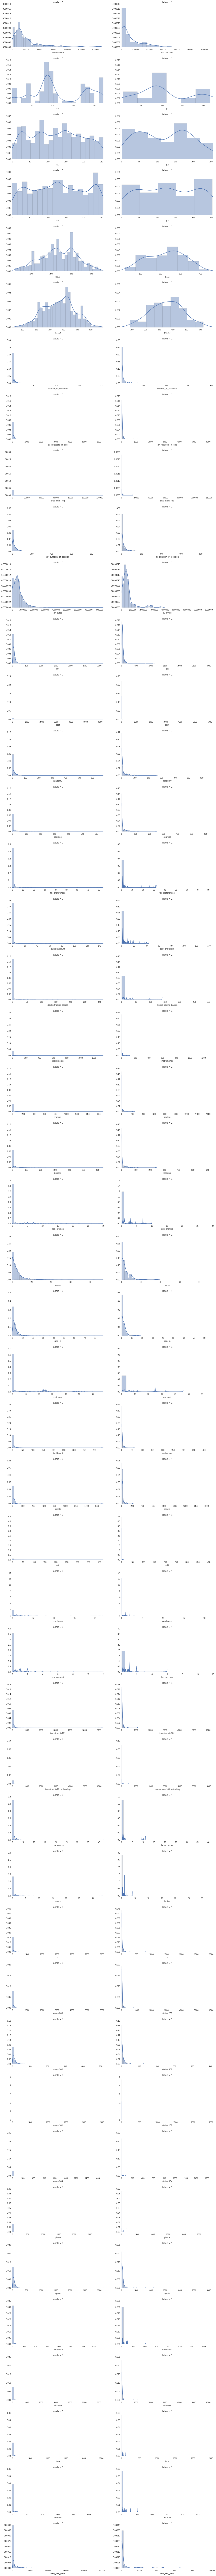

In [59]:
#слева - 0, справа - 1
n = len(data.columns)
fig, axes = plt.subplots(n, 2, figsize=(18, n*5))
plt.subplots_adjust(hspace = 0.3)

for col,ax_row in zip(data.columns,axes)[:n]:
    temp = data[col]
    for i,ax in enumerate(ax_row):
        sns.distplot(temp[labels == i],kde=True,ax = ax)
        ax.set_xlim([np.min(temp),np.max(temp)])
        titlename = 'labels = ' + str(i)
        ax.set_title(titlename)
    for i,ax in enumerate(ax_row):
        ax.set_ylim(np.maximum(ax_row[0].get_ylim(),ax_row[1].get_ylim()))

## Важность признаков

In [13]:
model = RandomForestRegressor(n_estimators=300,n_jobs= -1)
model.fit(np.array(data),labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

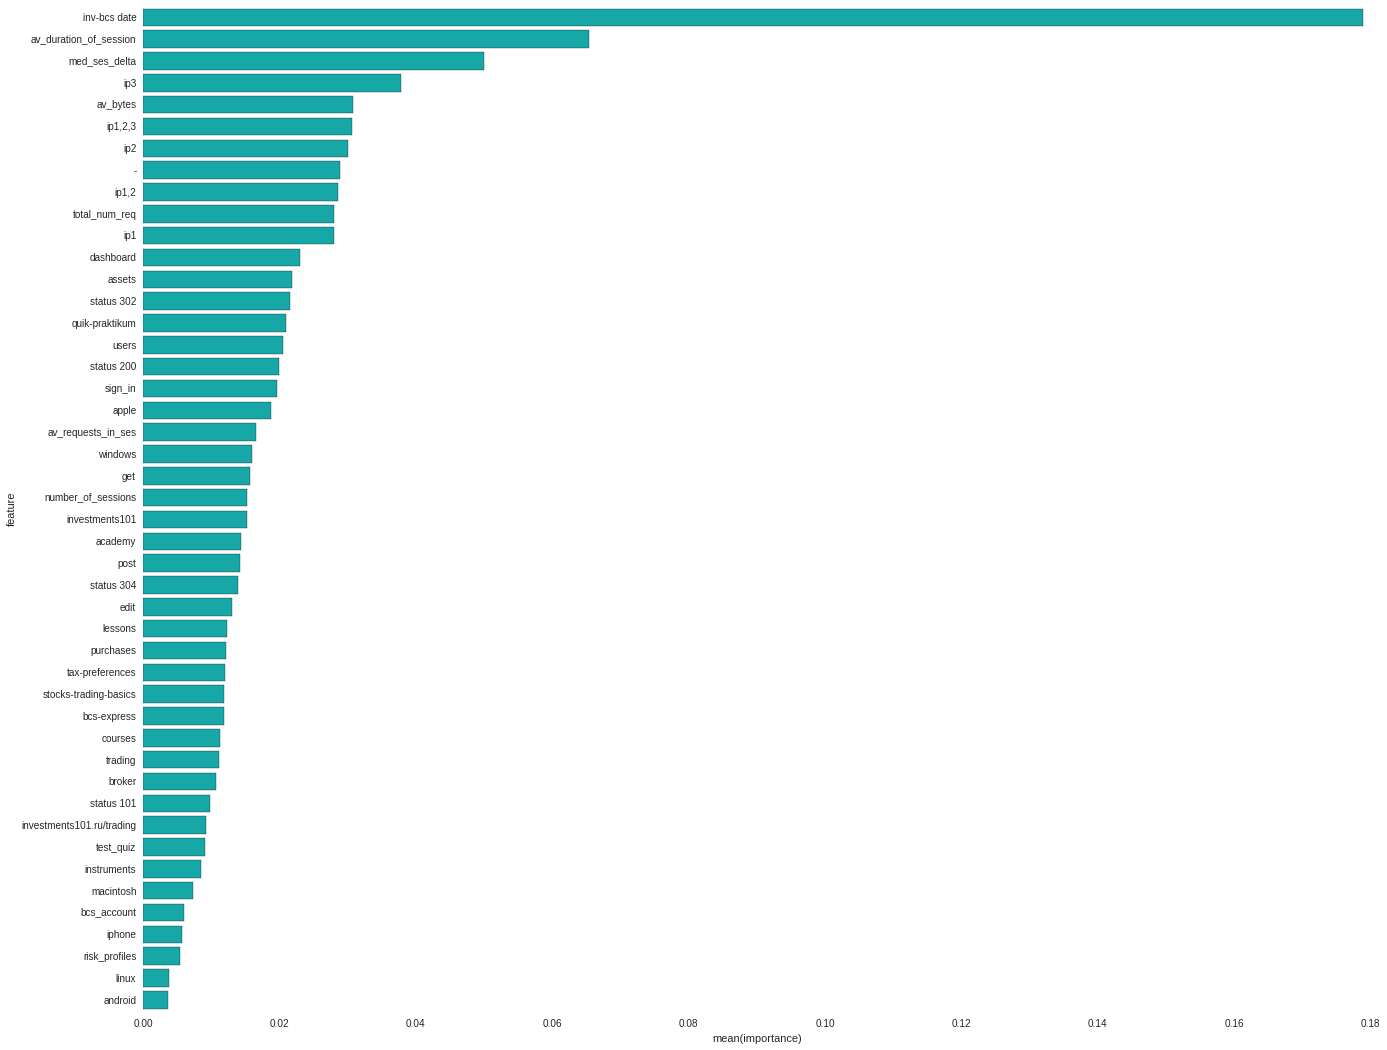

In [14]:
features = data.columns 
n_feat = 100
fig, ax = plt.subplots(1,1, figsize=(22, 18))
imp = pd.DataFrame({'feature':features, 'importance':model.feature_importances_})
imp.sort('importance', inplace=True, ascending=False)
sns.barplot(x='importance', y ='feature', data=imp[:n_feat], color='c',ax = ax)

## Классификация (1 - клиент, 0 - не клиент)

In [155]:
def cross_val(X,y,n_folds,rs,metric = roc_auc_score):
    n_elems = len(X)
    kf = cross_validation.KFold(n_elems, n_folds,shuffle = True,random_state = rs)
    predictions = []
    answers = []
    scores = []
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,7))

    for i,[train_index, test_index] in enumerate(kf):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        y_pred = rf(X_train, y_train, X_test)
        predictions.extend(y_pred)
        answers.extend(y_test)
        scores.append(metric(y_test,y_pred)) 
        
        
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
        plt.plot(fpr, tpr,lw = 1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    
    fpr, tpr, thresholds = roc_curve(np.array(answers),  np.array(predictions))
    plt.plot(fpr, tpr, label='ROC const. sol (area = %0.4f)' % 
             (metric(np.array(answers), np.array(predictions))))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return np.array(answers), np.array(predictions)

In [156]:
def rf(X_train, y_train, X_test): 
    #clf =  RandomForestClassifier(n_estimators = 350,n_jobs = -1,min_samples_leaf = 1)
    clf = xgb.XGBClassifier(n_estimators = 50,learning_rate=0.1, silent=True,
                 objective="binary:logistic", max_depth = 4,
                 nthread=-1, gamma= 0, min_child_weight = 2,colsample_bytree = 0.9,subsample = 0.9) 
    clf.fit(X_train, y_train)
    #print zip(clf.predict_proba(X_train)[:,0],y_train)
    
    return clf.predict_proba(X_test)[:,1]

-------------------------------------------------------------------------------------------------------


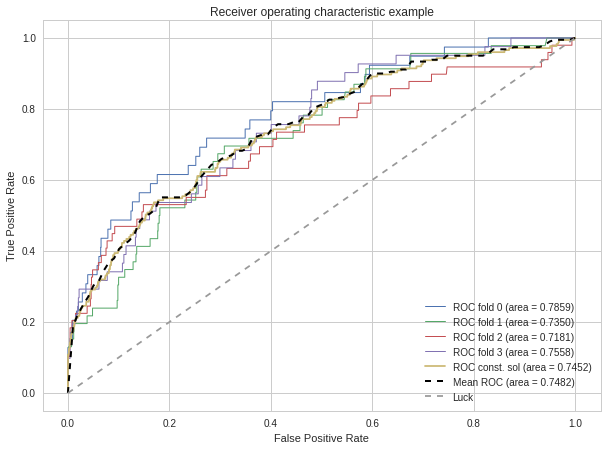

Constructed solution:
Share of positive objects in first (according to predicted probability) 10 objects: 1.0
Share of positive objects in first (according to predicted probability) 30 objects: 0.666666666667
Share of positive objects in first (according to predicted probability) 50 objects: 0.5
Share of positive objects in first (according to predicted probability) 70 objects: 0.414285714286
-------------------------------------------------------------------------------------------------------


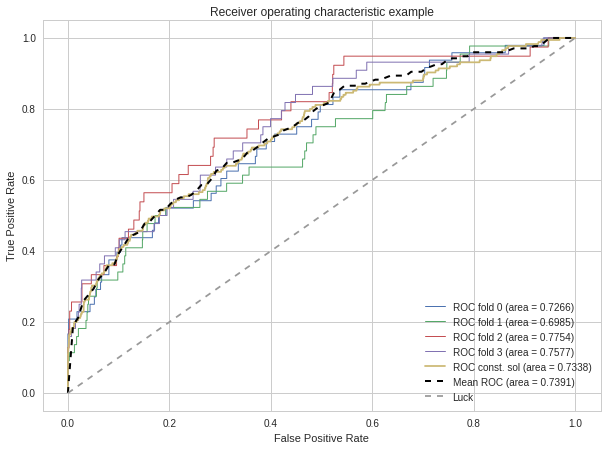

Constructed solution:
Share of positive objects in first (according to predicted probability) 10 objects: 1.0
Share of positive objects in first (according to predicted probability) 30 objects: 0.766666666667
Share of positive objects in first (according to predicted probability) 50 objects: 0.58
Share of positive objects in first (according to predicted probability) 70 objects: 0.442857142857
-------------------------------------------------------------------------------------------------------


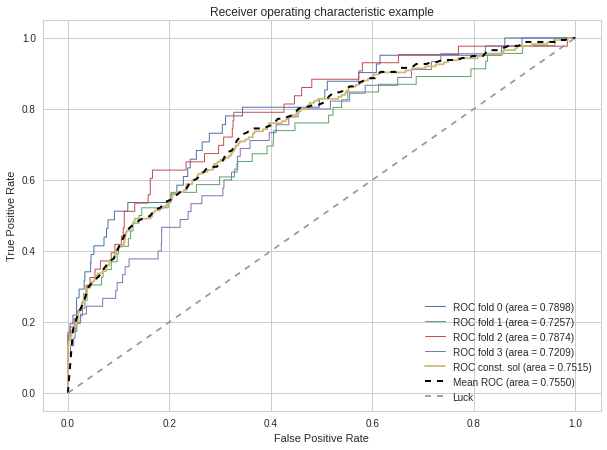

Constructed solution:
Share of positive objects in first (according to predicted probability) 10 objects: 1.0
Share of positive objects in first (according to predicted probability) 30 objects: 0.8
Share of positive objects in first (according to predicted probability) 50 objects: 0.56
Share of positive objects in first (according to predicted probability) 70 objects: 0.414285714286


In [157]:
for rs in [3,42,112]:
    print '-------------------------------------------------------------------------------------------------------'
    ans,pred =  cross_val(np.array(data),labels,4,rs)
    pred_ans = np.array(sorted(zip(pred,ans),reverse = True))
    print 'Constructed solution:'
    for n in [10,30,50,70]:
        pos = float(sum(pred_ans[:n,1] == 1))
        print 'Share of positive objects in first (according to predicted probability)',n,'objects:',pos/n